In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [3]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time
import pickle

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import nibabel as nib


# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras
from visualize import visualize_seg, visualize_seg_contour

Using TensorFlow backend.


In [4]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [19]:
def test_model(model_name, iter_num, gpu_id, file_prefix, indexing='ij', max_clip=0.7, n_test=1):    
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    
    images = []
    
    if n_test==1:
        t1_vol = nib.load("../data/t1_atlas.nii").get_data()[np.newaxis,:,:,:,np.newaxis]
        t1_seg = nib.load("../data/t1_atlas_seg.nii").get_data()[np.newaxis,:,:,:,np.newaxis]
        images.append([t1_vol, t1_seg])
    else:
        for step in range(0, n_test):
            vol_name, seg_name = test_brain_strings[step].split(",")
            X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
            images.append([X_vol, X_seg])
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
#     atlas_vol = nib.load('../data/t2_atlas_027_S_2219.nii').get_data()[np.newaxis,...,np.newaxis]
#     atlas_seg = nib.load('../data/t2_atlas_seg_027_S_2219.nii').get_data()
#     atlas_vol = atlas_vol/np.max(atlas_vol) * max_clip

    atlas_vol = nib.load("../data/t1_atlas.nii").get_data()[np.newaxis,:,:,:,np.newaxis]
    atlas_seg = nib.load("../data/t1_atlas_seg.nii").get_data()

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    trf_model = networks.trf_core(vol_size, nb_feats=len(good_labels)+1, indexing=indexing)

    # load weights of model
    with tf.device(gpu):
        net = networks.cvpr2018_net(vol_size, nf_enc, nf_dec)
        net.load_weights('../models/' + model_name +
                         '/' + str(iter_num) + '.h5')

        for idx in range(n_test):
            vol, seg = images[idx]
            pred = net.predict([vol, atlas_vol])
            all_labels = np.unique(seg)
            for l in all_labels:
                if l not in good_labels:
                    seg[seg==l] = 0
            for i in range(len(good_labels)):
                seg[seg==good_labels[i]] = i+1
            seg_onehot = tf.keras.utils.to_categorical(seg[0,:,:,:,0], num_classes=len(good_labels)+1)
            warp_seg_onehot = trf_model.predict([seg_onehot[tf.newaxis,:,:,:,:], pred[1]])
            warp_seg = np.argmax(warp_seg_onehot[0,:,:,:,:], axis=3)

            warp_seg_correct = np.zeros(warp_seg.shape)
            for i in range(len(good_labels)):
                warp_seg_correct[warp_seg==i+1] = good_labels[i]

            dice = kdice_fn([warp_seg_correct, atlas_seg])
            
            nii = nib.Nifti1Image(pred[0][0,:,:,:,0], np.eye(4))
            nib.save(nii, file_prefix + '_warped_' + str(idx) + '.nii')
            nii = nib.Nifti1Image(warp_seg_correct, np.eye(4))
            nib.save(nii, file_prefix + '_warped_seg_' + str(idx) + '.nii')
            nii = nib.Nifti1Image(pred[1][0,:,:,:,0], np.eye(4))
            nib.save(nii, file_prefix + '_flow_' + str(idx) + '.nii')
            
            print('dice', np.mean(dice))


In [7]:
atlas = nib.load("../data/t2_atlas_n_027_S_2219.nii").get_data()
atlas_seg = nib.load("../data/t2_atlas_seg_027_S_2219.nii").get_data()

In [8]:
good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
idx_map = {}
for i in range(len(good_labels)):
    idx_map[good_labels[i]] = i

regions = ['Brain-Stem', 'Thalamus', 'Cerebellum-Cortex', 'Cerebral-W.Matter', 'Cerebellum-W.Matter', 'Putamen', 'VentralDC', 'Palladium', 'Caudate', 'Lateral-Ventricle', 'Hippocampus', '3rd-Ventricle', '4th-Ventricle', 'Amygdala', 'Cerebral-Cortex', 'CSF', 'choroid-plexus']
reg_to_num_list = {'Brain-Stem': [16],
                   'Thalamus': [10, 46],
                   'Cerebellum-Cortex': [8, 47],
                   'Cerebral-W.Matter': [2, 41],
                   'Cerebellum-W.Matter': [7, 46],
                   'Putamen': [12, 51],
                   'VentralDC': [28, 60],
                   'Palladium': [13, 52],
                   'Caudate': [11, 50],
                   'Lateral-Ventricle': [4, 43],
                   'Hippocampus': [17, 53],
                   '3rd-Ventricle': [14],
                   '4th-Ventricle': [15],
                   'Amygdala': [18, 54],
                   'Cerebral-Cortex': [3, 42],
                   'CSF': [24],
                   'choroid-plexus': [31, 63]}

In [20]:
model_name = 'cvpr2018_vm2_l2'
num_iters = 0
gpu_id = 2
indexing = 'ij'
n_test = 10
file_prefix = '../scratch/test_vm_t1'

test_model(model_name, num_iters, gpu_id, file_prefix, indexing=indexing, n_test=n_test) 

# dices, warped, warped_seg, flow = test_model(model_name, num_iters, gpu_id, vol, seg, indexing=indexing)

Using GPU:2 with 0% of the memory
Using GPU:2 with 0% of the memory
dice 0.7638745
dice 0.7604443
dice 0.7737153
dice 0.76408917
dice 0.7458423
dice 0.75660384
dice 0.7387408
dice 0.7556359
dice 0.77153486
dice 0.7221853


In [16]:
all_labels = np.unique(seg)
print(len(all_labels))

39


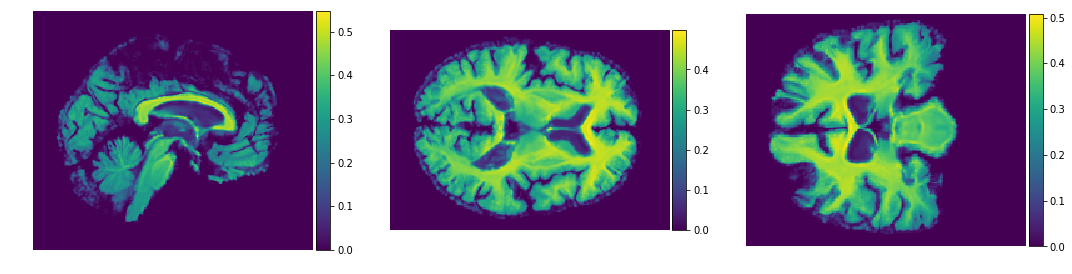

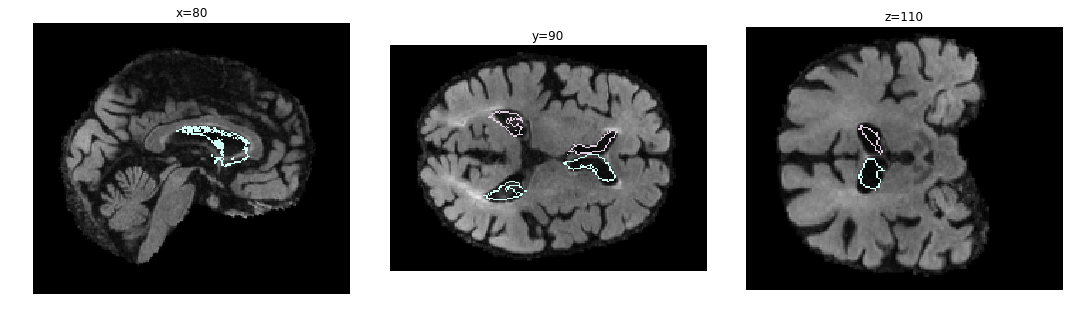

In [9]:
slices([warped[80,:,:], warped[:,90,:], warped[:,:,100]], do_colorbars=True, cmaps=['viridis', 'viridis', 'viridis'])
visualize_seg_contour(atlas, warped_seg, region_numbers=reg_to_num_list['Lateral-Ventricle'])


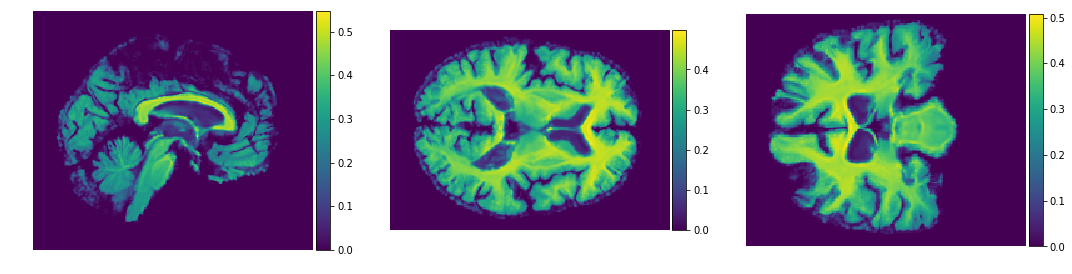

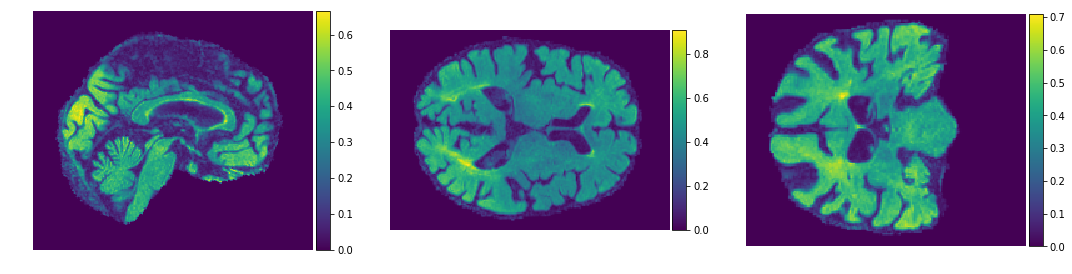

(<matplotlib.figure.Figure at 0x7f7068001240>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70487ebeb8>,
       dtype=object))

In [10]:
slices([warped[80,:,:], warped[:,90,:], warped[:,:,100]], do_colorbars=True, cmaps=['viridis', 'viridis', 'viridis'])
slices([atlas[80,:,:], atlas[:,90,:], atlas[:,:,100]], do_colorbars=True, cmaps=['viridis', 'viridis', 'viridis'])


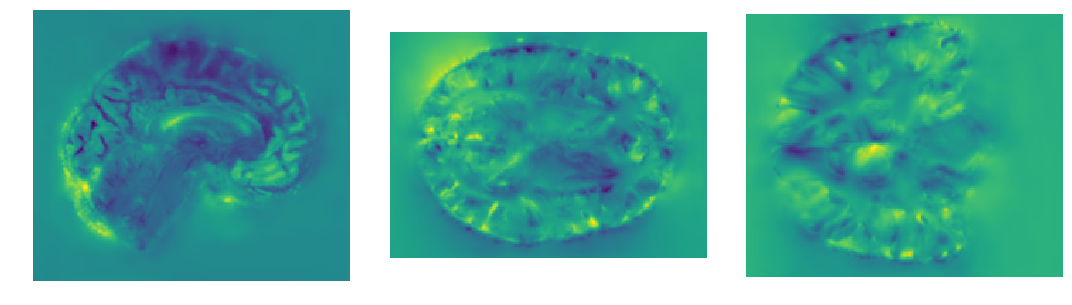

(<matplotlib.figure.Figure at 0x7f7032ef9da0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fec7e9978>,
       dtype=object))

In [20]:
slices([flow[80,:,:], flow[:,90,:], flow[:,:,100]])

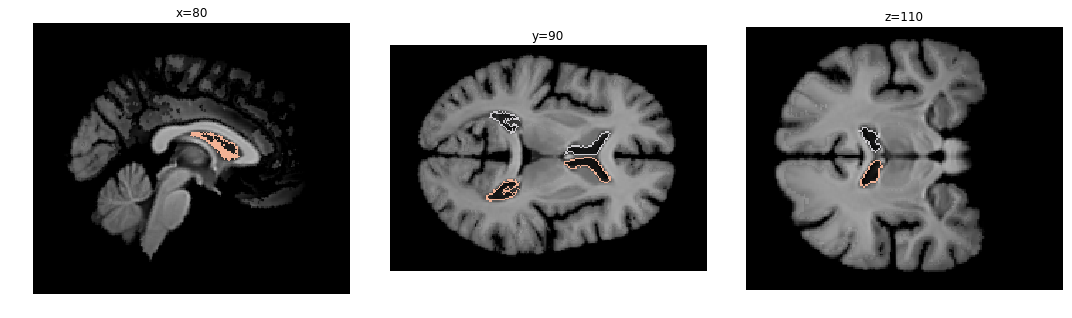

In [18]:
visualize_seg_contour(vol[0,:,:,:,0], seg[0,:,:,:,0], region_numbers=reg_to_num_list['Lateral-Ventricle'])

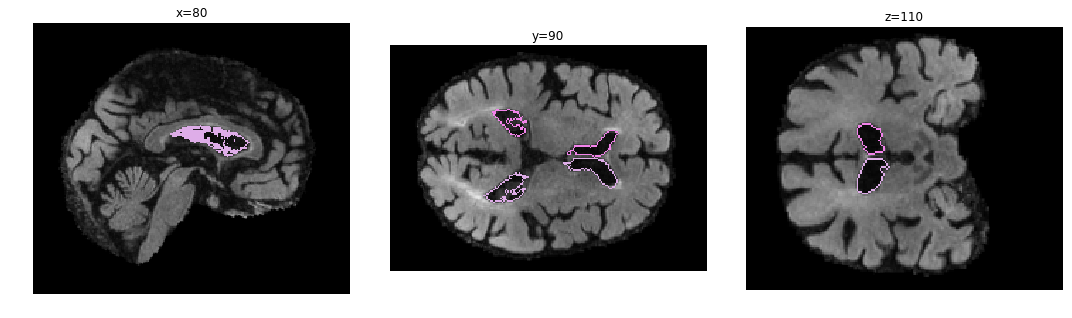

In [27]:
visualize_seg_contour(atlas, warped_seg, region_numbers=reg_to_num_list['Lateral-Ventricle'])

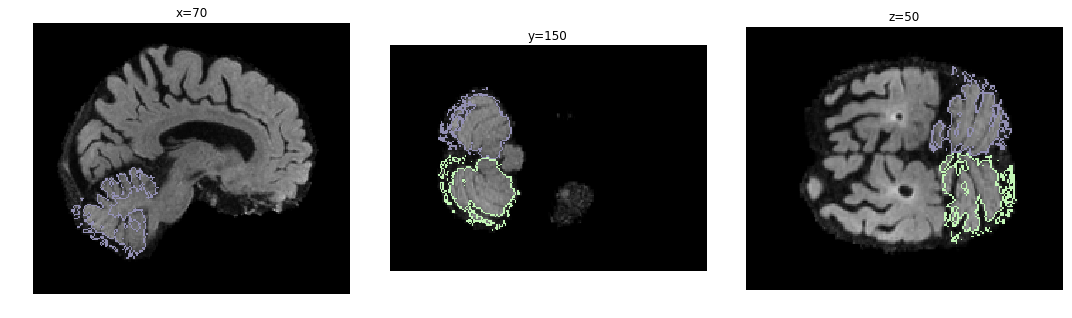

In [28]:
visualize_seg_contour(atlas, warped_seg, region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])

In [11]:
nii = nib.Nifti1Image(warped, np.eye(4))
nib.save(nii, '../scratch/test_mi.nii')
nii = nib.Nifti1Image(warped_seg, np.eye(4))
nib.save(nii, '../scratch/test_mi_seg.nii')